In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import chardet
image_path = '/content/drive/My Drive/flickr30k-images/'


with open("/content/drive/My Drive/tags30k.txt", 'rb') as f:
    result = chardet.detect(f.read())

# Read CSV file with detected encoding
data = pd.read_csv("/content/drive/My Drive/tags30k.txt", encoding=result['encoding'])
data


,image,caption
0,1000092795.jpg,hands hair look young hanging yard guys shaggy
1,1000092795.jpg,many are young bushes White males outside
2,1000092795.jpg,standing are men green shirts yard
3,1000092795.jpg,garden standing blue shirt man
4,1000092795.jpg,time enjoy friends spent
...,...,...
158910,998845445.jpg,pilot boat rail shirt background leans shorts ...
158911,998845445.jpg,hill like side fog young man hanging is boat r...
158912,998845445.jpg,leaning water blue side man is boat white body...
158913,998845445.jpg,mountains riding harbor background fog man boa...


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/My Drive/flickr30k-images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: str(x).lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = data['caption']+ " endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[141, 5, 8, 1299, 9, 616, 145, 1]

In [ ]:
model = ResNet50()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
file = open('/content/drive/My Drive/resnet_model_features.pkl', 'rb')
features = pickle.load(file)

# dump information to that file
# for image in tqdm(data['image'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features[image] = feature

# pickle.dump(features, open('resnet_model_features.pkl', 'wb'))


In [ ]:
new_size = len(features['120542286.jpg'][0])

In [ ]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [ ]:
input1 = Input(shape=(new_size,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
plot_model(caption_model)
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          524544      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "ResNet50_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/25
2110/2110 [==============================] - ETA: 0s - loss: 5.8659
Epoch 1: val_loss improved from inf to 5.84074, saving model to ResNet50_model.h5
2110/2110 [==============================] - 1009s 476ms/step - loss: 5.8659 - val_loss: 5.8407 - lr: 0.0010
Epoch 2/25
2110/2110 [==============================] - ETA: 0s - loss: 5.4162
Epoch 2: val_loss improved from 5.84074 to 5.65491, saving model to ResNet50_model.h5
2110/2110 [==============================] - 225s 107ms/step - loss: 5.4162 - val_loss: 5.6549 - lr: 0.0010
Epoch 3/25
2110/2110 [==============================] - ETA: 0s - loss: 5.2566
Epoch 3: val_loss improved from 5.65491 to 5.54521, saving model to ResNet50_model.h5
2110/2110 [==============================] - 224s 106ms/step - loss: 5.2566 - val_loss: 5.5452 - lr: 0.0010
Epoch 4/25
2110/2110 [==============================] - ETA: 0s - loss: 5.1391
Epoch 4: val_loss improved from 5.54521 to 5.46693, saving model to ResNet50_model.h5
2110/2110 [========

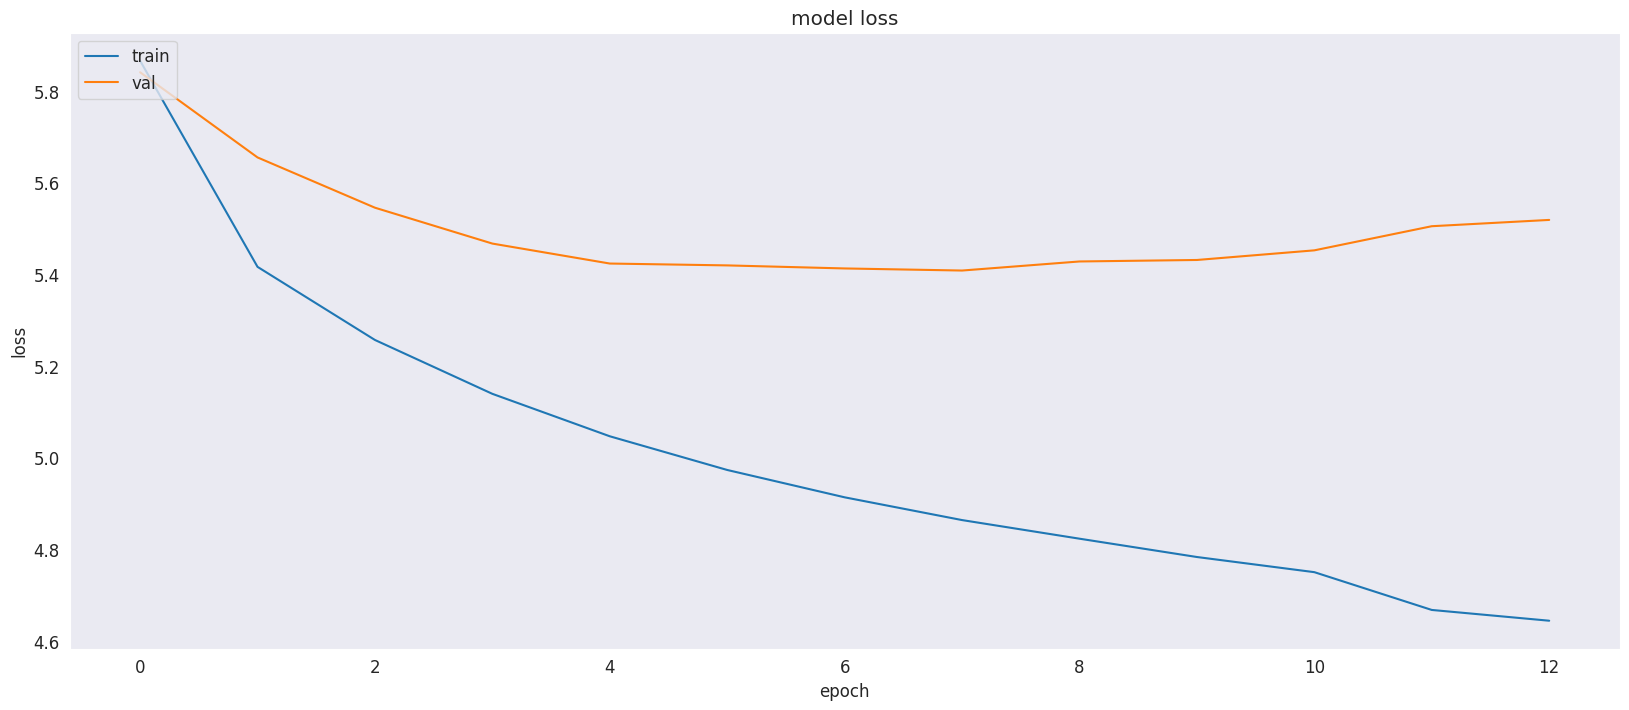

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    caption = caption[len("startseq"):-len("endseq")]
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 31ms/step


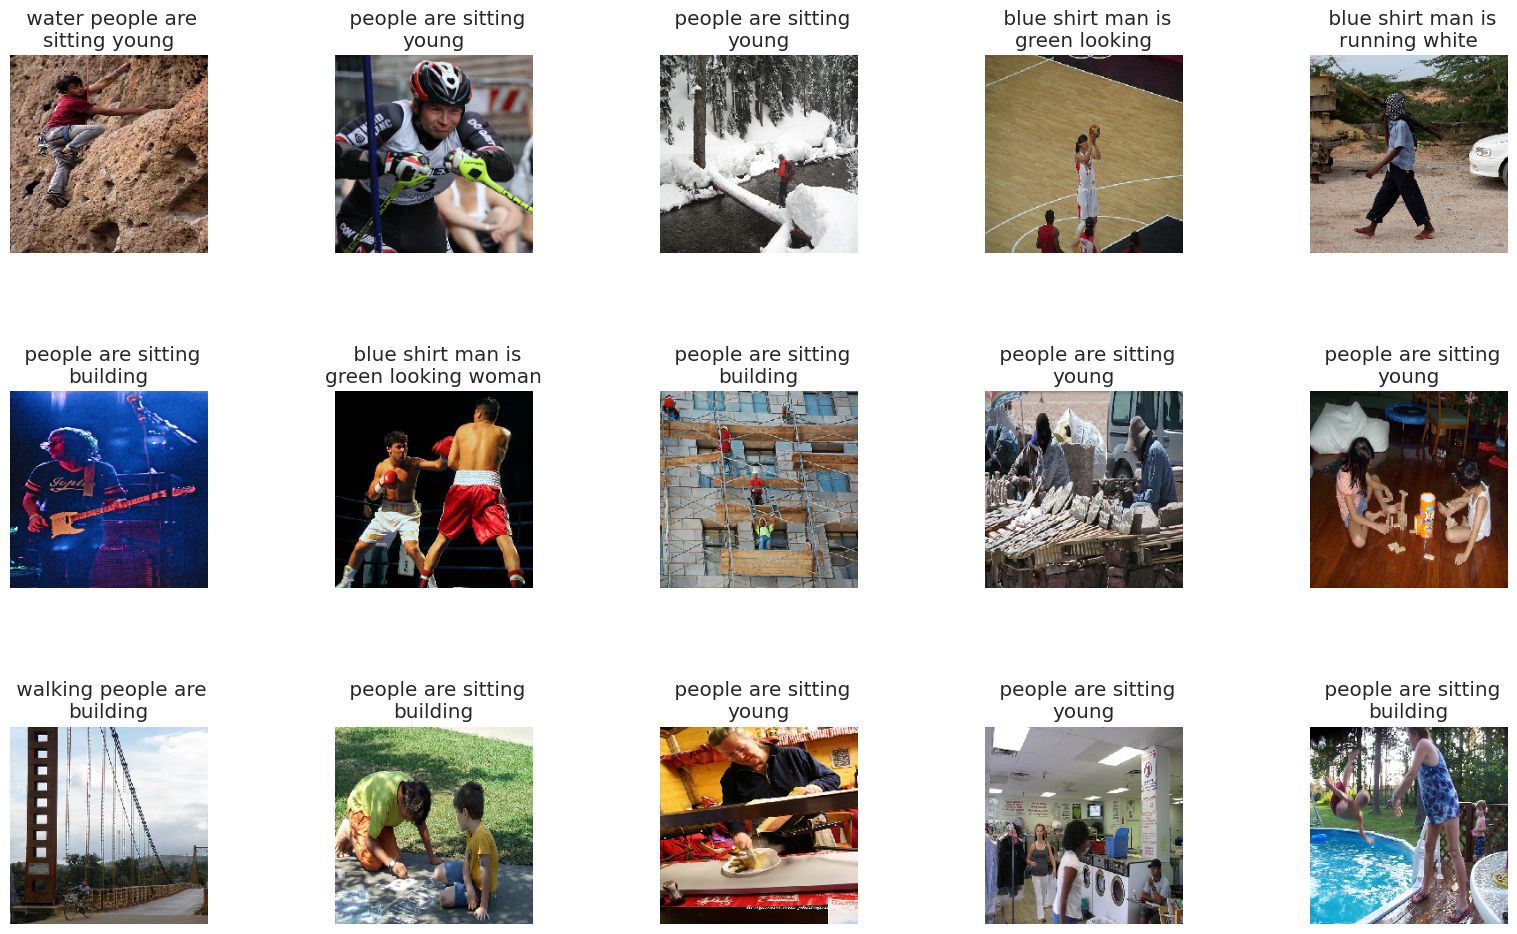

In [ ]:
display_images(samples)

1/1 [==============================] - 1s 801ms/step



startseq water water water water water water water water water water water water water water water water water water water water water background background is large endseq


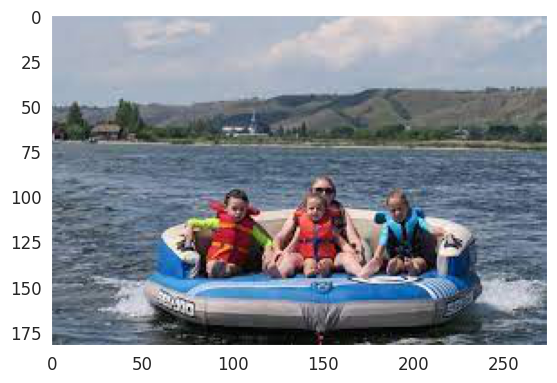

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from keras.models import Model, load_model
from keras.applications.xception import Xception
from tensorflow.keras.utils import pad_sequences
from pickle import load


def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
             return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text
img_path = '/content/drive/My Drive/ImagesToTest/1.jpg'

model = caption_model
ResNet50_model = ResNet50(include_top=False, pooling="avg")

photo = extract_features(img_path, ResNet50_model)
img = Image.open(img_path)
description = generate_desc(caption_model, tokenizer, photo, max_length)

print("\n\n")
print(description)
plt.imshow(img)